In [1]:
# Import TensorFlow and its Keras API components
# Models - provides classes to build, manage, and train neural network models
# Layers - contains all the building blocks of a neural network.
import tensorflow as tf
from tensorflow.keras import models, layers

# Import Matplotlib for visualizing training metrics, images, or model performance
import matplotlib.pyplot as plt

In [2]:
# Number of images processed in one forward/backward pass.
# Higher batch size = faster training but requires more memory.
BATCH_SIZE = 32

# Target height/width (in pixels) to which all images will be resized.
# Ensures uniform input size for the neural network.
IMAGE_SIZE = 256

# Number of color channels in the image.
# 3 channels = RGB images (standard color pictures).
CHANNELS = 3

# Number of complete passes through the entire dataset during training.
# More epochs = better learning, but risk of overfitting if too high.
EPOCHS = 50

In [3]:
# Load images from the 'PlantVillage' directory and create a TensorFlow dataset.
# This utility automatically labels images based on their subfolder names.
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",      # Path to the root dataset folder
    shuffle=True,        # Randomize the order of images for better training
    image_size=IMAGE_SIZE,  # Resize all images to (IMAGE_SIZE x IMAGE_SIZE)
    batch_size=BATCH_SIZE   # Number of images per batch during training
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[1 0 1 1 0 0 2 1 1 0 0 1 2 0 2 1 0 0 0 0 0 1 0 1 1 0 1 0 1 1 0 0]


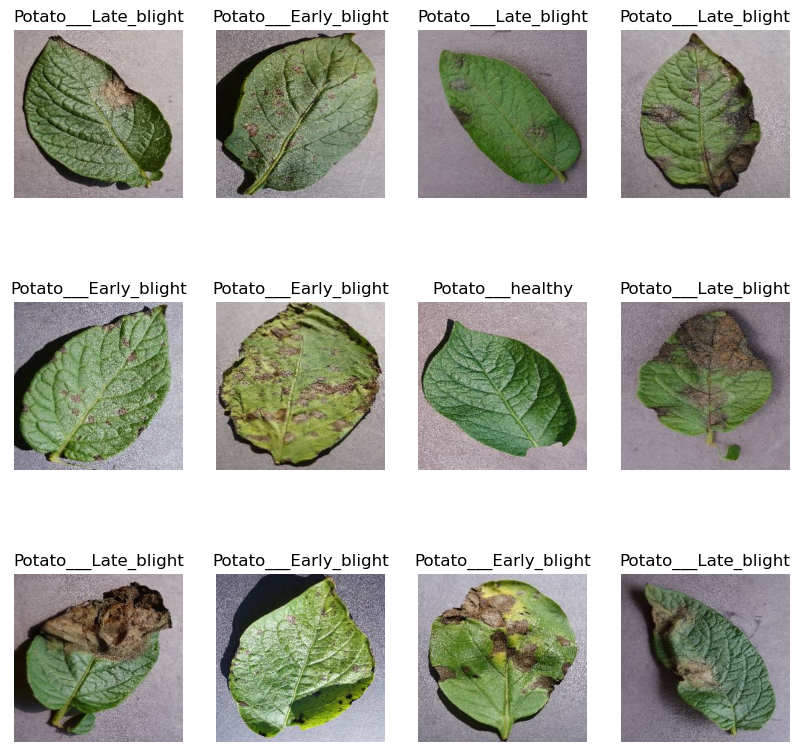

In [5]:
# Create a plotting canvas of size 10x10 for displaying sample images.
plt.figure(figsize=(10, 10))

# Take one batch from the dataset to visualize images and their labels.
for image_batch, labels_batch in dataset.take(1):
    
    # Display the shape of the image batch.
    # Format: (batch_size, height, width, channels)
    print(image_batch.shape)

    # Display the corresponding numeric labels for the batch.
    print(labels_batch.numpy())

    # Plot the first 12 images from the batch.
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)

        # Show the image as uint8 (0–255) to display correctly.
        plt.imshow(image_batch[i].numpy().astype("uint8"))

        # Set the title using the class name (mapped from label).
        plt.title(class_names[labels_batch[i]])

        # Hide axis ticks for cleaner visualization.
        plt.axis("off")

In [6]:
# Dividing the dataset into train and test
# 80% ---> Training 
# 20% ---> Testing (10% Validation and 10% Testing)
# We have 68 data batches having 32 images each. So we have 54 images in training, 6 in validation and 8 in testing from each batch

In [7]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [8]:
train_ds = dataset.take(54)
len(train_ds)

54

In [9]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [10]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [11]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [12]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [13]:
def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, 
                           shuffle=True, shuffle_size=10000):
    """
    Splits a dataset into training, validation, and test subsets.

    Parameters:
    ds (tf.data.Dataset): Input dataset to split
    train_split (float): Fraction of data for training
    val_split (float): Fraction of data for validation
    test_split (float): Fraction of data for testing
    shuffle (bool): Whether to shuffle the dataset before splitting
    shuffle_size (int): Buffer size for shuffling
    
    Returns:
    train_ds, val_ds, test_ds (tf.data.Dataset): Partitioned datasets
    """

    # Ensure provided splits sum to 1
    assert (train_split + val_split + test_split) == 1, "Splits must sum to 1"

    ds_size = len(ds)  # Total number of batches/images

    # Shuffle dataset for random sampling (important for training performance)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    # Calculate dataset sizes
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    # Partition dataset
    train_ds = ds.take(train_size)
    val_ds   = ds.skip(train_size).take(val_size)
    test_ds  = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [17]:
print(f'Training dataset size:{len(train_ds)} \nValidation dataset size:{len(val_ds)} \nTesting dataset size:{len(test_ds)}')

Training dataset size:54 
Validation dataset size:6 
Testing dataset size:8


In [20]:
# Improve performance by caching data, shuffling, and preparing next batch in background.
# AUTOTUNE optimizes pipeline performance based on available hardware.
# cache() - Stores data in memory so it loads faster in subsequent epochs
# shuffle(1000)	- Randomizes samples — helps reduce training bias
# prefetch() - Loads future batches in background — improves GPU utilization

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds   = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds  = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0.6666667  0.6745098  0.7254902 ]
  [0.6666667  0.6745098  0.7254902 ]
  [0.67058825 0.6784314  0.7294118 ]
  ...
  [0.7529412  0.7647059  0.8       ]
  [0.73333335 0.74509805 0.78039217]
  [0.76862746 0.78039217 0.8156863 ]]

 [[0.6862745  0.69411767 0.74509805]
  [0.68235296 0.6901961  0.7411765 ]
  [0.68235296 0.6901961  0.7411765 ]
  ...
  [0.76862746 0.78039217 0.8156863 ]
  [0.7490196  0.7607843  0.79607844]
  [0.75686276 0.76862746 0.8039216 ]]

 [[0.6666667  0.6745098  0.7254902 ]
  [0.6666667  0.6745098  0.7254902 ]
  [0.6627451  0.67058825 0.72156864]
  ...
  [0.7921569  0.8039216  0.8392157 ]
  [0.7647059  0.7764706  0.8117647 ]
  [0.74509805 0.75686276 0.7921569 ]]

 ...

 [[0.46666667 0.44313726 0.49019608]
  [0.5764706  0.5529412  0.6       ]
  [0.52156866 0.49803922 0.54509807]
  ...
  [0.40784314 0.38431373 0.4392157 ]
  [0.36862746 0.34509805 0.4       ]
  [0.42745098 0.40392157 0.45882353]]

 [[0.5803922  0.5568628  0.6039216 ]
  [0.49803922 0.4745098  0.52156866]


In [23]:
# Preprocessing layer: resize input images & scale pixel values to [0,1]
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255) # Normalization
])

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"), # Randomly flip images in both directions
    layers.RandomRotation(0.2)  # Random rotation up to 20%
])